In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from xgboost import XGBRegressor
from scipy.stats import randint
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
os.chdir("C:\\Users\\omkarp\\Downloads\\")
data = pd.read_csv('DATA_Sto5.csv')
data = data.dropna()
data = data.reset_index(drop=True)
data

,FID_grid,x,y,week,season,count_trips,TEn_ur,THin_ur,TOth_ur,Resi_lur,...,LUP_Resi,LUP_Comm,LUP_Edu,LUP_Recre,LUP_Public,LUP_Health,LUP_Other,T_Enable,T_Hinder,T_Other
0,10,671201.8641,6.575992e+06,weekday,Winter,7,0.0,0.0,0.0,0.00001,...,0,25,0,0,0,0,0,0,0,0
1,10,671201.8641,6.575992e+06,weekend,Winter,14,0.0,0.0,0.0,0.00001,...,0,25,0,0,0,0,0,0,0,0
2,17,674001.8641,6.575992e+06,weekday,Winter,8,0.0,0.0,0.0,0.00001,...,0,6,0,0,0,0,0,0,0,0
3,18,674401.8641,6.575992e+06,weekday,Winter,5,0.0,0.0,0.0,0.00001,...,0,0,0,0,0,0,62,0,0,0
4,18,674401.8641,6.575992e+06,weekend,Winter,5,0.0,0.0,0.0,0.00001,...,0,0,0,0,0,0,62,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,896,672001.8641,6.586392e+06,weekend,Summer,12,0.0,1.0,0.0,0.00000,...,0,0,0,0,0,0,0,0,12,0
2711,897,672401.8641,6.586392e+06,weekday,Fall,7,0.0,0.0,0.0,0.00001,...,0,50,0,0,0,0,0,0,0,0
2712,897,672401.8641,6.586392e+06,weekend,Fall,9,0.0,0.0,0.0,0.00001,...,0,50,0,0,0,0,0,0,0,0
2713,897,672401.8641,6.586392e+06,weekday,Summer,22,0.0,0.0,0.0,0.00001,...,0,50,0,0,0,0,0,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2715 entries, 0 to 2714
Data columns (total 44 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FID_grid     2715 non-null   int64  
 1   x            2715 non-null   float64
 2   y            2715 non-null   float64
 3   week         2715 non-null   object 
 4   season       2715 non-null   object 
 5   count_trips  2715 non-null   int64  
 6   TEn_ur       2715 non-null   float64
 7   THin_ur      2715 non-null   float64
 8   TOth_ur      2715 non-null   float64
 9   Resi_lur     2715 non-null   float64
 10  Comm_lur     2715 non-null   float64
 11  Edu_lur      2715 non-null   float64
 12  Recre_lur    2715 non-null   float64
 13  Public_lur   2715 non-null   float64
 14  Health_lur   2715 non-null   float64
 15  Other_lur    2715 non-null   float64
 16  entropy      2715 non-null   float64
 17  AreaProx     2715 non-null   float64
 18  Pop_den      2715 non-null   float64
 19  PopM_d

# Feature Selection

74.39189686924493
29.0


<Axes: xlabel='count_trips', ylabel='Count'>

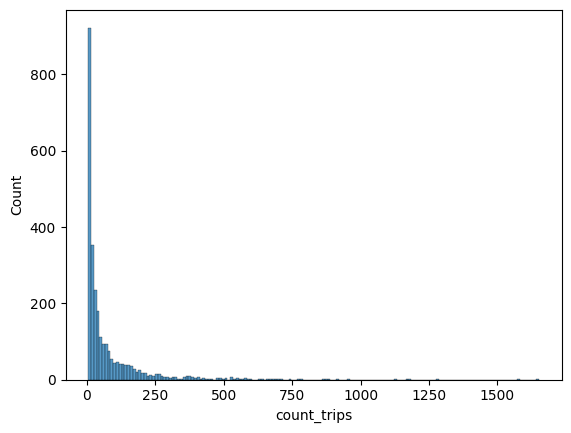

In [4]:
print(data['count_trips'].mean())
print(data['count_trips'].median())
sns.histplot(data['count_trips'])

In [5]:
day_encoder = OneHotEncoder(sparse=False, drop='first')
day_encoded = day_encoder.fit_transform(data[['week']])
day_columns = day_encoder.get_feature_names(['week'])
day_df = pd.DataFrame(day_encoded, columns=day_columns)
data = pd.concat([data, day_df], axis=1)

month_encoder = OneHotEncoder(sparse=False, drop='first')
month_encoded = month_encoder.fit_transform(data[['season']])
month_columns = month_encoder.get_feature_names(['season'])
month_df = pd.DataFrame(month_encoded, columns=month_columns)
data = pd.concat([data, month_df], axis=1)
data = data.drop(['week', 'season'], axis=1)
data.head()

,FID_grid,x,y,count_trips,TEn_ur,THin_ur,TOth_ur,Resi_lur,Comm_lur,Edu_lur,...,LUP_Public,LUP_Health,LUP_Other,T_Enable,T_Hinder,T_Other,week_weekend,season_Spring,season_Summer,season_Winter
0,10,671201.8641,6.575992e+06,7,0.0,0.0,0.0,0.00001,1.00001,0.00001,...,0,0,0,0,0,0,0.0,0.0,0.0,1.0
1,10,671201.8641,6.575992e+06,14,0.0,0.0,0.0,0.00001,1.00001,0.00001,...,0,0,0,0,0,0,1.0,0.0,0.0,1.0
2,17,674001.8641,6.575992e+06,8,0.0,0.0,0.0,0.00001,1.00001,0.00001,...,0,0,0,0,0,0,0.0,0.0,0.0,1.0
3,18,674401.8641,6.575992e+06,5,0.0,0.0,0.0,0.00001,0.00001,0.00001,...,0,0,62,0,0,0,0.0,0.0,0.0,1.0
4,18,674401.8641,6.575992e+06,5,0.0,0.0,0.0,0.00001,0.00001,0.00001,...,0,0,62,0,0,0,1.0,0.0,0.0,1.0


In [6]:
data.columns

Index(['FID_grid', 'x', 'y', 'count_trips', 'TEn_ur', 'THin_ur', 'TOth_ur',
       'Resi_lur', 'Comm_lur', 'Edu_lur', 'Recre_lur', 'Public_lur',
       'Health_lur', 'Other_lur', 'entropy', 'AreaProx', 'Pop_den', 'PopM_den',
       'PopF_den', 'Empl_den', 'MEmpl_den', 'FEmpl_den', 'Inc_den', 'Veh_den',
       'Vused_den', 'Vunus_den', 'Rd_Pri', 'Rd_Sec', 'Rd_Ter', 'Rd_Cyc',
       'Rd_Pedes', 'Rd_Other', 'LUP_Resi', 'LUP_Comm', 'LUP_Edu', 'LUP_Recre',
       'LUP_Public', 'LUP_Health', 'LUP_Other', 'T_Enable', 'T_Hinder',
       'T_Other', 'week_weekend', 'season_Spring', 'season_Summer',
       'season_Winter'],
      dtype='object')

## Feature Importance

In [7]:
selected_columns = ['count_trips', 'TEn_ur', 'THin_ur', 'TOth_ur','Resi_lur', 'Comm_lur', 'Edu_lur',
                    'Recre_lur', 'Public_lur','Health_lur', 'Other_lur', 'entropy', 'AreaProx', 'Pop_den', 'PopM_den',
                    'PopF_den', 'Empl_den', 'MEmpl_den','FEmpl_den','Inc_den','Veh_den','Vused_den','Vunus_den', 'Rd_Pri',
                    'Rd_Sec', 'Rd_Ter', 'Rd_Cyc','Rd_Pedes', 'Rd_Other', 'LUP_Resi', 'LUP_Comm', 'LUP_Edu', 'LUP_Recre',
                    'LUP_Public', 'LUP_Health', 'LUP_Other', 'T_Enable', 'T_Hinder','T_Other', 'week_weekend', 'season_Spring',
                    'season_Summer','season_Winter']

dependent_var = 'count_trips'
independent_vars = selected_columns.copy()
independent_vars.remove(dependent_var)

X = data[independent_vars]
y = data[dependent_var]

In [8]:
rf = RandomForestRegressor()
rf.fit(X, y)
importances = rf.feature_importances_
feature_names = X.columns

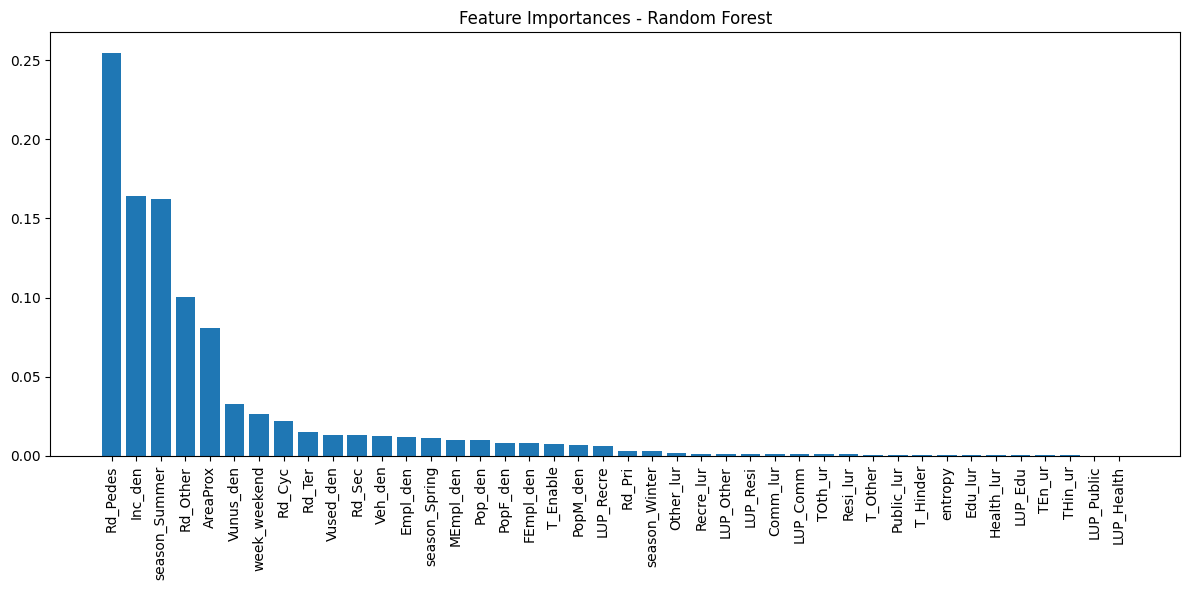

In [9]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [10]:
importance_scores = {feature_names[i]: importances[i] for i in range(len(importances))}
sorted_importances = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)
top_50_columns = [item[0] for item in sorted_importances[:60]]
print(top_50_columns)

['Rd_Pedes', 'Inc_den', 'season_Summer', 'Rd_Other', 'AreaProx', 'Vunus_den', 'week_weekend', 'Rd_Cyc', 'Rd_Ter', 'Vused_den', 'Rd_Sec', 'Veh_den', 'Empl_den', 'season_Spring', 'MEmpl_den', 'Pop_den', 'PopF_den', 'FEmpl_den', 'T_Enable', 'PopM_den', 'LUP_Recre', 'Rd_Pri', 'season_Winter', 'Other_lur', 'Recre_lur', 'LUP_Other', 'LUP_Resi', 'Comm_lur', 'LUP_Comm', 'TOth_ur', 'Resi_lur', 'T_Other', 'Public_lur', 'T_Hinder', 'entropy', 'Edu_lur', 'Health_lur', 'LUP_Edu', 'TEn_ur', 'THin_ur', 'LUP_Public', 'LUP_Health']


## VIF (variance_inflation_factor)

In [11]:
sorted_feature_names = top_50_columns
sorted_feature_names.remove('Other_lur')
sorted_feature_names.remove('TOth_ur')

In [12]:
features_test = sorted_feature_names
col_test = data[features_test]

vif_data = pd.DataFrame()
vif_data["feature"] = col_test.columns
vif_data["VIF"] = [variance_inflation_factor(col_test.values.astype(float), i)
                          for i in range(len(col_test.columns))]

vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data.to_string(index=False, float_format='%.2f'))

      feature        VIF
      Pop_den 6379171.64
     Empl_den 5129902.14
     PopF_den 1606902.53
     PopM_den 1591049.53
    FEmpl_den 1297637.56
    MEmpl_den 1278254.84
      Veh_den  634175.68
    Vused_den  442483.18
    Vunus_den   18711.00
      entropy      16.95
      Inc_den      15.07
       Rd_Ter       9.81
     AreaProx       6.75
     Rd_Pedes       6.45
       TEn_ur       5.40
       Rd_Cyc       4.21
    Recre_lur       3.50
     Resi_lur       3.38
   Health_lur       3.15
     T_Enable       3.11
      THin_ur       3.07
     Comm_lur       2.99
      Edu_lur       2.98
   LUP_Health       2.98
    LUP_Recre       2.68
   Public_lur       2.68
       Rd_Sec       2.54
      LUP_Edu       2.31
     T_Hinder       2.25
     LUP_Resi       2.19
season_Summer       2.18
   LUP_Public       2.12
     Rd_Other       2.06
season_Winter       2.04
 week_weekend       1.96
season_Spring       1.89
       Rd_Pri       1.84
     LUP_Comm       1.79
    LUP_Other       1.57


In [13]:
sorted_feature_names = vif_data[vif_data['VIF'] < 20]['feature']
print(len(sorted_feature_names))
sorted_feature_names=sorted_feature_names.tolist()
sorted_feature_names

31


['entropy',
 'Inc_den',
 'Rd_Ter',
 'AreaProx',
 'Rd_Pedes',
 'TEn_ur',
 'Rd_Cyc',
 'Recre_lur',
 'Resi_lur',
 'Health_lur',
 'T_Enable',
 'THin_ur',
 'Comm_lur',
 'Edu_lur',
 'LUP_Health',
 'LUP_Recre',
 'Public_lur',
 'Rd_Sec',
 'LUP_Edu',
 'T_Hinder',
 'LUP_Resi',
 'season_Summer',
 'LUP_Public',
 'Rd_Other',
 'season_Winter',
 'week_weekend',
 'season_Spring',
 'Rd_Pri',
 'LUP_Comm',
 'LUP_Other',
 'T_Other']

C:\Users\omkarp\AppData\Local\Temp\ipykernel_8156\3543444763.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


[Text(0, 0.5, 'Inc_den'),
 Text(0, 1.5, 'Rd_Ter'),
 Text(0, 2.5, 'AreaProx'),
 Text(0, 3.5, 'Rd_Pedes'),
 Text(0, 4.5, 'TEn_ur'),
 Text(0, 5.5, 'Rd_Cyc'),
 Text(0, 6.5, 'Recre_lur'),
 Text(0, 7.5, 'Resi_lur'),
 Text(0, 8.5, 'THin_ur'),
 Text(0, 9.5, 'Comm_lur'),
 Text(0, 10.5, 'Edu_lur'),
 Text(0, 11.5, 'LUP_Health'),
 Text(0, 12.5, 'LUP_Recre'),
 Text(0, 13.5, 'Rd_Sec'),
 Text(0, 14.5, 'LUP_Edu'),
 Text(0, 15.5, 'LUP_Resi'),
 Text(0, 16.5, 'season_Summer'),
 Text(0, 17.5, 'LUP_Public'),
 Text(0, 18.5, 'Rd_Other'),
 Text(0, 19.5, 'season_Winter'),
 Text(0, 20.5, 'week_weekend'),
 Text(0, 21.5, 'season_Spring'),
 Text(0, 22.5, 'Rd_Pri'),
 Text(0, 23.5, 'LUP_Comm'),
 Text(0, 24.5, 'LUP_Other'),
 Text(0, 25.5, 'T_Other')]

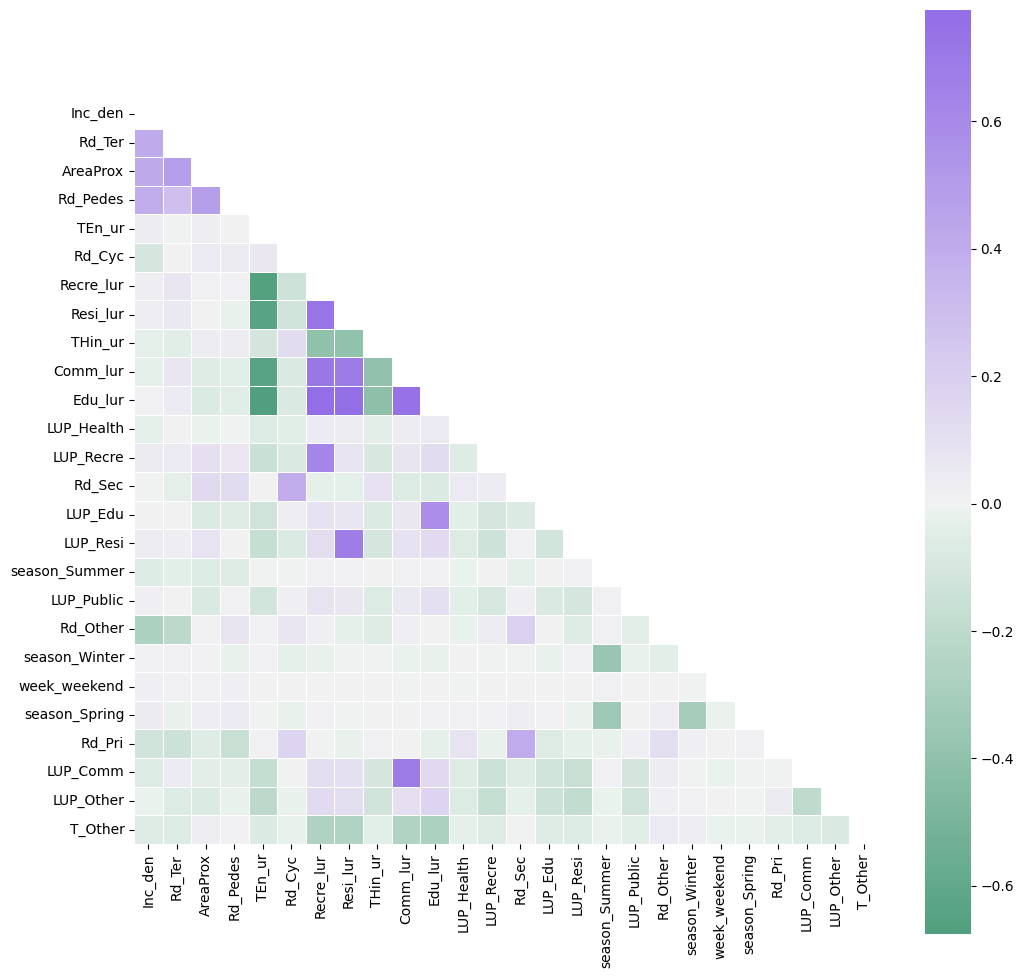

In [14]:
sorted_feature_names.remove('entropy')
sorted_feature_names.remove('T_Enable')
sorted_feature_names.remove('T_Hinder')
sorted_feature_names.remove('Health_lur')
sorted_feature_names.remove('Public_lur')
# sorted_feature_names.remove('Recre_lur')  # Features to remove for lower correlation
# sorted_feature_names.remove('Edu_lur')
# sorted_feature_names.remove('Comm_lur')
# sorted_feature_names.remove('LUP_Resi')
# sorted_feature_names.remove('TEn_ur')
# sorted_feature_names.remove('Inc_den')
# sorted_feature_names.remove('Rd_Pedes')
# sorted_feature_names.remove('Rd_Comml')

features_1 = sorted_feature_names
corr = data[features_1].corr('spearman')
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True,linewidths=.5, cbar_kws={"shrink": 1})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 10)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 10)

In [15]:
print(len(features_1))
X = data[features_1].values
y = data['count_trips'].values
features_1

26


['Inc_den',
 'Rd_Ter',
 'AreaProx',
 'Rd_Pedes',
 'TEn_ur',
 'Rd_Cyc',
 'Recre_lur',
 'Resi_lur',
 'THin_ur',
 'Comm_lur',
 'Edu_lur',
 'LUP_Health',
 'LUP_Recre',
 'Rd_Sec',
 'LUP_Edu',
 'LUP_Resi',
 'season_Summer',
 'LUP_Public',
 'Rd_Other',
 'season_Winter',
 'week_weekend',
 'season_Spring',
 'Rd_Pri',
 'LUP_Comm',
 'LUP_Other',
 'T_Other']

# Random Forest Model

In [16]:
x_train, x_test, y_train, y_test=train_test_split(X, y, test_size=0.2)

In [17]:
rf = RandomForestRegressor(random_state=42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean squared error: {:.2f}".format(mse))
print("RMSE: %f" % (rmse))
print("R-squared score: {:.2f}".format(r2))

Mean squared error: 1589.82
RMSE: 39.872555
R-squared score: 0.88


In [18]:
param_dist = {'n_estimators': [100, 150, 200, 250],
              'max_depth': list(np.arange(1, len(features_1), 2)),
              'max_features': list(np.arange(3, len(features_1), 2))}

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=10, n_jobs=-1)

with tqdm(total=1) as pbar:
        random_search.fit(x_train, y_train)
        pbar.update(1)

print("Best Hyperparameters: ", random_search.best_params_)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:17<00:00, 197.18s/it]

Best Hyperparameters:  {'n_estimators': 100, 'max_features': 15, 'max_depth': 25}


In [19]:
best_params = random_search.best_params_
rf = RandomForestRegressor(**best_params, random_state=42)

scoring = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
cv_results = cross_validate(rf, X, y, cv=10, scoring=scoring, return_estimator=True)
estimators = cv_results['estimator']

test_r2_scores = []
test_mse_scores = -cv_results['test_neg_mean_squared_error']
test_rmse_scores = -cv_results['test_neg_root_mean_squared_error']
test_mae_scores = -cv_results['test_neg_mean_absolute_error']

for i, estimator in enumerate(estimators):
    y_pred = estimator.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    test_r2_scores.append(r2)
    
print("Mean CV R2 score:", np.mean(test_r2_scores))
print("Mean CV MSE score:", np.mean(test_mse_scores))
print("Mean CV RMSE score:", np.mean(test_rmse_scores))
print("Mean CV MAE score:", np.mean(test_mae_scores))

Mean CV R2 score: 0.9390999626312354
Mean CV MSE score: 9561.62292334102
Mean CV RMSE score: 80.55352259774882
Mean CV MAE score: 40.98218465945707


In [20]:
rf.fit(x_train, y_train)
importances = rf.feature_importances_
print(features_1, importances)

['Inc_den', 'Rd_Ter', 'AreaProx', 'Rd_Pedes', 'TEn_ur', 'Rd_Cyc', 'Recre_lur', 'Resi_lur', 'THin_ur', 'Comm_lur', 'Edu_lur', 'LUP_Health', 'LUP_Recre', 'Rd_Sec', 'LUP_Edu', 'LUP_Resi', 'season_Summer', 'LUP_Public', 'Rd_Other', 'season_Winter', 'week_weekend', 'season_Spring', 'Rd_Pri', 'LUP_Comm', 'LUP_Other', 'T_Other'] [0.20072807 0.02896863 0.13232712 0.20440884 0.00169684 0.02962315
 0.00485682 0.00190588 0.00117593 0.00287827 0.00271362 0.00038547
 0.02387994 0.01926228 0.00086421 0.0032632  0.15776237 0.00163911
 0.10959766 0.00896341 0.03191767 0.01267849 0.0058314  0.00303574
 0.00884036 0.00079553]


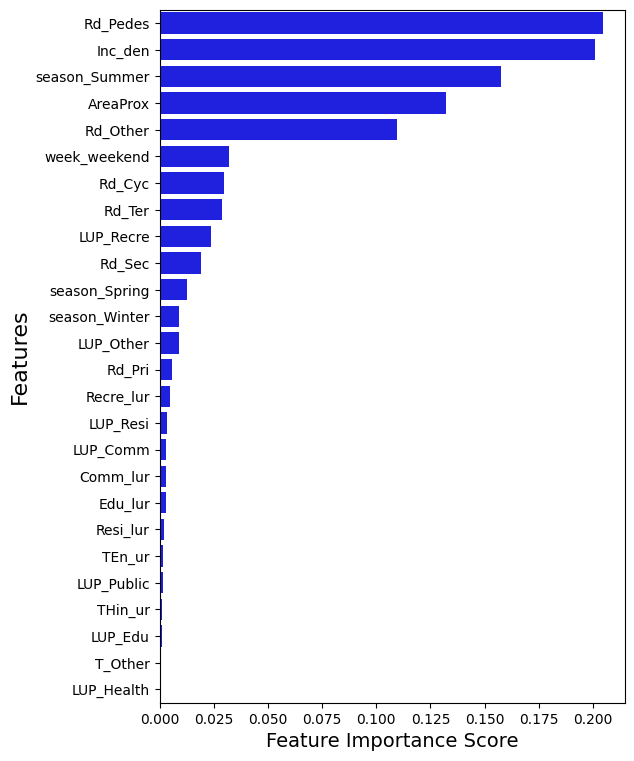

In [21]:
result1 = pd.DataFrame({"features":features_1, "importances":rf.feature_importances_})
result = result1.sort_values(by='importances',ascending=False)
plt.figure(figsize=(6,9))
sns.barplot(x=result['importances'], y=result['features'], color='blue')
plt.xlabel('Feature Importance Score', fontsize='14')
plt.ylabel('Features', fontsize='16')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# XGBoost Model

In [22]:
import xgboost as xgb
model = None
model = XGBRegressor(n_estimators=10, max_depth=20, verbosity=0)
model.fit(x_train, y_train)
model.predict(x_train)

xgbr = xgb.XGBRegressor(verbosity=0) 
xgbr.fit(x_train, y_train)
score = xgbr.score(x_train, y_train)  
print("Training score: ", score)

scores = cross_val_score(xgbr, x_train, y_train,cv=10)
print("Mean cross-validation R2: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, x_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

ypred = xgbr.predict(x_test)
mse = mean_squared_error(y_test, ypred)
print(f'mse: ', mse , '\nrmse: ',mse**(1/2) )

Training score:  0.9981986979808048
Mean cross-validation R2: 0.90
K-fold CV average score: 0.86
mse:  987.9213804509836 
rmse:  31.431216655595495


## Hyperparameter optimisation

In [23]:
regressor=xgb.XGBRegressor(objective="reg:squarederror")
n_estimators = [50,100,500,900,1100,1500]
max_depth = [2,3,5,10,15, 20, 25]
booster = ['gbtree', 'gblinear']
learning_rate = [0.05, 0.1, 0.15, 0.2]
min_child_weight = [1,2,3,4,5]
base_score = [0.25,0.5,0.75,1]

hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
}

random_cv= RandomizedSearchCV(estimator=regressor,param_distributions=hyperparameter_grid,
                             cv=10, n_iter=5, scoring='neg_mean_absolute_error',
                             n_jobs=4, verbose=2, return_train_score=True,
                             random_state=123)

In [24]:
with tqdm(file=sys.stdout, desc="RandomizedSearchCV") as pbar:
        random_result = random_cv.fit(x_train, y_train)
        pbar.update()
    
print(f'The best hyperparameters are {random_result.best_params_}')

RandomizedSearchCV: 0it [00:00, ?it/s]Fitting 10 folds for each of 5 candidates, totalling 50 fits
RandomizedSearchCV: 1it [01:03, 63.95s/it]
The best hyperparameters are {'n_estimators': 1100, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.2, 'booster': 'gbtree', 'base_score': 0.75}


In [25]:
# Training with best hyperparameters
base_score = 0.75
n_estimators = 1100
learning_rate = 0.2
min_child_weight = 2
max_depth = 5
booster = 'gbtree'

regressor = xgb.XGBRegressor(base_score=base_score, booster=booster, colsample_bylevel=1,colsample_bynode=1,colsample_bytree=1,
                             enable_categorical=False,gamma=0, importance_type=None,interaction_constraints='',
                             learning_rate=learning_rate, max_delta_step=0,max_depth=max_depth, min_child_weight=min_child_weight,
                             n_estimators=n_estimators, n_jobs=8,num_parallel_tree=1, predictor='gpu_predictor',random_state=0,
                             reg_alpha=0,reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
                             validate_parameters=1, verbosity=0)
regressor.fit(x_train,y_train)

XGBRegressor(base_score=0.75, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=0, max_depth=5,
             max_leaves=None, min_child_weight=2, missing=nan,
             monotone_constraints=None, n_estimators=1100, n_jobs=8,
             num_parallel_tree=1, predictor='gpu_predictor', random_state=0, ...)

In [26]:
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
cv_results = cross_validate(regressor, x_train, y_train, cv=10, scoring=scoring)

mse_scores = -cv_results['test_neg_mean_squared_error']
rmse_scores = mse_scores ** 0.5
mae_scores = -cv_results['test_neg_mean_absolute_error']
r2_scores = cv_results['test_r2']

print("Mean MSE:", mse_scores.mean())
print("Mean RMSE:", rmse_scores.mean())
print("Mean MAE:", mae_scores.mean())
print("Mean R2:", r2_scores.mean())

Mean MSE: 1103.109817135556
Mean RMSE: 31.499470540709865
Mean MAE: 14.582711242367711
Mean R2: 0.9330297558349919


In [27]:
importances = regressor.feature_importances_
print(features_1, importances)

['Inc_den', 'Rd_Ter', 'AreaProx', 'Rd_Pedes', 'TEn_ur', 'Rd_Cyc', 'Recre_lur', 'Resi_lur', 'THin_ur', 'Comm_lur', 'Edu_lur', 'LUP_Health', 'LUP_Recre', 'Rd_Sec', 'LUP_Edu', 'LUP_Resi', 'season_Summer', 'LUP_Public', 'Rd_Other', 'season_Winter', 'week_weekend', 'season_Spring', 'Rd_Pri', 'LUP_Comm', 'LUP_Other', 'T_Other'] [0.11082084 0.01818379 0.08471201 0.269679   0.01062013 0.02797694
 0.00942678 0.00959845 0.01490915 0.00083815 0.00316247 0.00233185
 0.03753399 0.01730513 0.00257937 0.00335553 0.11850826 0.01384187
 0.2011314  0.0018702  0.01235276 0.00874921 0.00695219 0.00380499
 0.00652207 0.00323349]


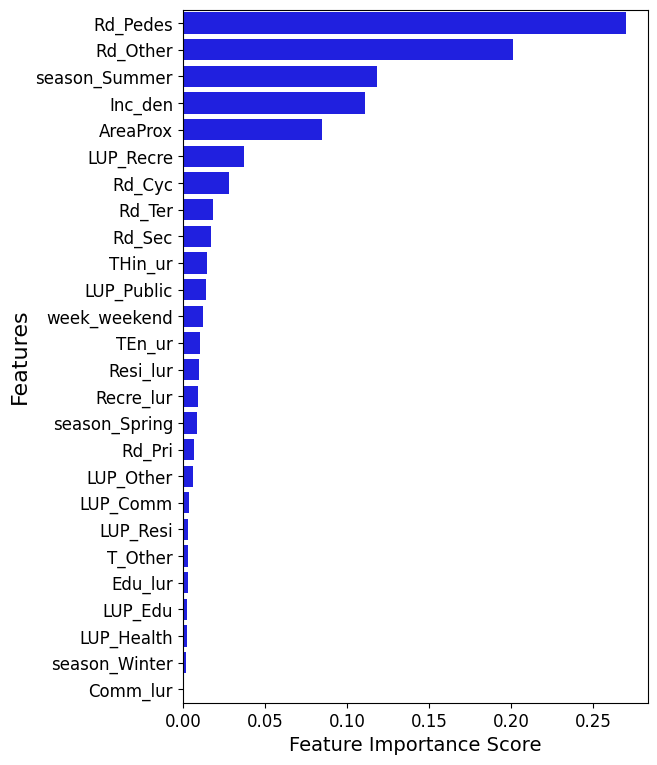

In [28]:
result1 = pd.DataFrame({"features":features_1, "importances":regressor.feature_importances_})
result = result1.sort_values(by='importances',ascending=False)
plt.figure(figsize=(6,9))
sns.barplot(x=result['importances'], y=result['features'], color='blue')
plt.xlabel('Feature Importance Score', fontsize='14')
plt.ylabel('Features', fontsize='16')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

In [29]:
print(result)

         features  importances
3        Rd_Pedes     0.269679
18       Rd_Other     0.201131
16  season_Summer     0.118508
0         Inc_den     0.110821
2        AreaProx     0.084712
12      LUP_Recre     0.037534
5          Rd_Cyc     0.027977
1          Rd_Ter     0.018184
13         Rd_Sec     0.017305
8         THin_ur     0.014909
17     LUP_Public     0.013842
20   week_weekend     0.012353
4          TEn_ur     0.010620
7        Resi_lur     0.009598
6       Recre_lur     0.009427
21  season_Spring     0.008749
22         Rd_Pri     0.006952
24      LUP_Other     0.006522
23       LUP_Comm     0.003805
15       LUP_Resi     0.003356
25        T_Other     0.003233
10        Edu_lur     0.003162
14        LUP_Edu     0.002579
11     LUP_Health     0.002332
19  season_Winter     0.001870
9        Comm_lur     0.000838
